In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence
from sqlalchemy import or_

In [3]:
from snorkel.lf_helpers import *
import pickle

Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
from sqlalchemy import  or_, and_,any_

In [5]:
with open('../candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    cands = pickle.load(f)

In [6]:
# LF to load gold labels
def return_gold_labels(c):
#     splt=None
#     if c.id in cands[0].keys():
#         splt=0
        
#     if c.id in cands[1].keys():
#         splt=1
        
#     if c.id in cands[2].keys():
#         splt=2
        
#     if splt:
#         return cands[splt][c.id]['label']
#     else:
#         print 'Error: not found (cand id = %i)'%c.id
#         return 0
    
    try:
        return cands[0][c.id]['label']
    except KeyError:
        try:
            return cands[1][c.id]['label']
        except KeyError:
            try:
                return cands[2][c.id]['label']
            except KeyError:
                return 0

In [7]:
# LF to load gold labels
def return_gold_labels2(c):
    
    try:
        return cands[0][c.id]['label']
    except KeyError:
        try:
            return cands[1][c.id]['label']
        except KeyError:
            try:
                return cands[2][c.id]['label']
            except KeyError:
                return 0

In [8]:
from snorkel.models import Candidate, candidate_subclass
REGULATOR = candidate_subclass('REGULATOR', ['Chemical', 'Gene'])

In [9]:
LFs = [
    return_gold_labels,
    return_gold_labels2
]

# Drop the unmapped labels

In [10]:
for k in range (3):
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, REGULATOR.gold_labels.any())).count()
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, ~REGULATOR.gold_labels.any())).count()

12968
0
3237
0
8278
0


In [11]:
# #get all ids to drop (in train-dev & without labels)
# todrop = list(map(lambda x: x.id ,session.query(REGULATOR).filter(and_(REGULATOR.split.in_([0,1]), ~REGULATOR.labels.any())).all()))
# print 'Will drop %i candidates'%len(todrop)

In [12]:
# session.query(REGULATOR).filter(REGULATOR.id.in_(todrop)).delete(synchronize_session=False)
# session.commit()

In [13]:
# #check if deleted
# session.query(REGULATOR).filter(~(REGULATOR.labels.any())).count()

** Handle Candidate labels? **

In [14]:
# #check if deleted
# session.query(Candidate).filter(~(Candidate.labels.any())).count()

In [15]:
# session.query(Candidate).filter(Candidate.id.in_(todrop)).delete(synchronize_session=False)
# session.commit()

In [16]:
# #check if deleted
# session.query(Candidate).filter(~(Candidate.labels.any())).count()

# Train the generative model (denoise)

In [17]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [18]:
# combined train+dev marginals from previous step (saved in the same split number dureing preprocessing)

In [19]:
# save train. set marginals
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 14.6 s, sys: 44 ms, total: 14.7 s
Wall time: 14.7 s


<12968x2 sparse matrix of type '<type 'numpy.int64'>'
	with 25936 stored elements in Compressed Sparse Row format>

In [20]:
# see how many LF vote on how many examples & with how many other LFs there are votes on common examples
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
return_gold_labels,0,1.0,1.0,0.0
return_gold_labels2,1,1.0,1.0,0.0


In [21]:
# actual training of the gen. model
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0 , #deps=deps,
)

Inferred cardinality: 2


In [22]:
train_marginals = gen_model.marginals(L_train)

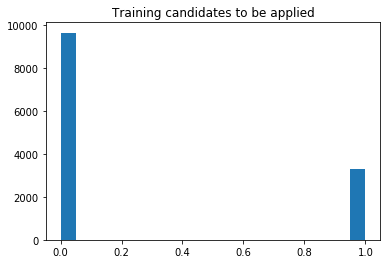

In [23]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.title('Training candidates to be applied')
plt.show()

In [24]:
# save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 12968 marginals


In [26]:
# ~~ Not needed below

In [27]:
# L_test = labeler.apply_existing(split=2)

In [28]:
# # load from db gold labels
# L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
# L_gold_test

In [29]:
# _ = gen_model.error_analysis(session, L_test, L_gold_test)

In [30]:
# L_test.lf_stats(session, L_gold_test, gen_model.learned_lf_stats()['Accuracy'])

# LSTM training

In [25]:
from snorkel.annotations import load_gold_labels,load_marginals

In [28]:
from snorkel.annotations import load_marginals

train_cands  = session.query(REGULATOR).filter(REGULATOR.split == 0).all()
val_cands  = session.query(REGULATOR).filter(REGULATOR.split == 1).all()
test_cands  = session.query(REGULATOR).filter(REGULATOR.split == 2).all()


train_marginals = load_marginals(session, split=0)
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True, zero_one=True)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

In [37]:
from snorkel.learning import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 1,
    'batch_size': 32
}

lstm = reRNN(seed=1701, n_threads=None,)
lstm.train(train_cands, train_marginals, X_dev = val_cands , Y_dev = L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=12876  #epochs=5  batch size=32
[reRNN] Epoch 0 (62.67s)	Average loss=0.446107	Dev F1=28.29
[reRNN] Epoch 1 (128.78s)	Average loss=0.272050	Dev F1=30.15
[reRNN] Epoch 2 (194.45s)	Average loss=0.202075	Dev F1=52.41
[reRNN] Epoch 3 (259.97s)	Average loss=0.164214	Dev F1=52.98
[reRNN] Epoch 4 (325.50s)	Average loss=0.147661	Dev F1=51.44
[reRNN] Model saved as <reRNN>
[reRNN] Training done (330.06s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-4
[reRNN] Loaded model <reRNN>


# Evaluate on test

In [41]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)
print_pos_prf(len(tp), len(fp), len(tn), len(fn))

Scores (Un-adjusted)
Pos. class accuracy: 0.479
Neg. class accuracy: 0.908
Precision            0.623
Recall               0.479
F1                   0.542
----------------------------------------
TP: 952 | FP: 576 | TN: 5716 | FN: 1034



In [53]:
print_pos_prf(tp,fp,tn,fn)

Precision (+):	 0.62 
Recall (+):	 0.59 
F1 score (+):	 0.61 



In [51]:
def print_pos_prf(tp,fp,tn,fn):
    prec = (1.0*tp/(tp+fp))
    rec = (1.0*tp/ (fp+fn))
    f1 = 2*prec*rec/(prec+rec)
    print "Precision (+):\t %.2f \nRecall (+):\t %.2f \nF1 score (+):\t %.2f \n"%(prec,rec, f1)